In [1]:
using JuMP, COSMO, MosekTools
using DynamicPolynomials, LinearAlgebra, SumOfSquares
using Plots, LaTeXStrings, Latexify

### Denoising towards the Neil Parabola without Equations 

We consider  Neil's Parabola in the plane with coordinates $(Z_1,Z_2)$ given both by an equation and a parametrization:


In [2]:
@polyvar a Z[1:2]
f = a^2*Z[2]^2 - Z[1]^3

a²Z₂² - Z₁³

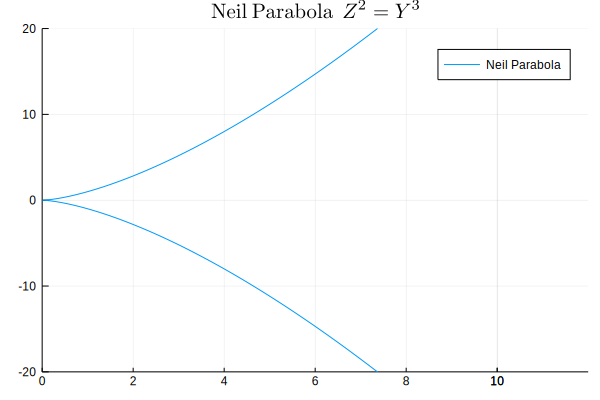

In [3]:
# define a simple parameterized hypersurface

# Neil Parabola
a = 1
s(x) = [x^2, a*x^3] # polynomial parameterization
plottitle = L"\mathrm{Neil\: Parabola\:\: }  Z^2 = Y^3"
plot([Tuple(s(x)) for x in -20:0.01:20 ], seriestype=:path, xlims=(0,12), ylims=(-20,20), label=string("Neil Parabola") , title=plottitle) 

Via the semilocal hierarchy introduced in `Chapter 4` of the thesis, it is possible to recover some point $z = s(x)$ on the parabola from a (small) corruption $u = s(x_0)+\eta$ of some point $z_0 = s(x_0)$. If $\eta$ is a normal at the smooth point $s(x_0)$, then $z$ will be equal to $z_0$. On the other hand, around the singularity $z_0 = (0, 0)$, three different cases may occur and one recovers the correct point in two of them. 

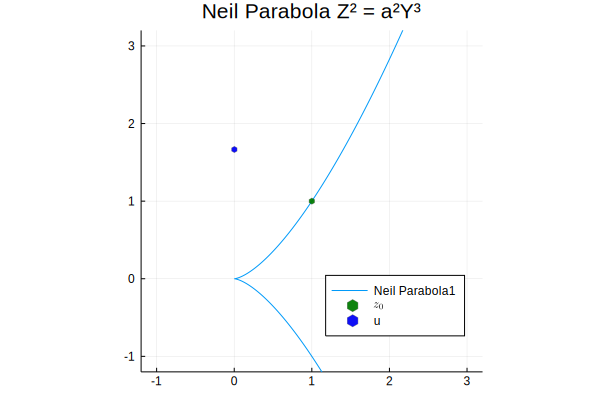

In [4]:
n=1;
d=3; # Parameterization degree
D=3; # ideal of relations is generated in degree D

@polyvar X
x₀ = 1; 
z₀ = s(x₀);
ε = 1.2;
Js = Polynomial.(MultivariatePolynomials.differentiate(s(X), [X]))

# the following code distinguishes three different types of normals at the singularity
# for all x₀≠0, the definitions make no difference. 

#ν₀ = x₀≠0 ? vec(nullspace([∂(X=>x₀) for ∂ in Js]')) : (a->[-2abs(a); a])(randn()) # get the normal at x₀, many-to-one case at singularity
ν₀ = x₀≠0 ? vec(nullspace([∂(X=>x₀) for ∂ in Js]')) : [1; 0] # get the normal at x₀, one-to-many case at singularity
#ν₀ = x₀≠0 ? vec(nullspace([∂(X=>x₀) for ∂ in Js]')) : (a->[abs(a); 4abs(a)])(randn()) # get the normal at x₀, one-to-one case at singularity

u = z₀ + ε.*ν₀ ; # starting point 

plotradius = [-1-ε, 1+ε] 
plot([Tuple(s(x)) for x in (x₀-20):0.01:(x₀+20)], seriestype=:path, xlims=Tuple(z₀[1].+plotradius), ylims=Tuple(z₀[2].+plotradius), label=string("Neil Parabola", a), legend=:bottomright, title="Neil Parabola Z² = a²Y³ ",  aspect_ratio=:equal) #"Neil Parabola for a="
scatter!(Tuple(z₀), 
    markershape = :hexagon,
    markersize = 3,
    markeralpha = 0.9,
    markercolor = :green,
    markerstrokewidth = 0.5,
    markerstrokealpha = 0.4,
    markerstrokecolor = :black,
    label=L"z_0"
)
scatter!(Tuple(u), 
    markershape = :hexagon,
    markersize = 3,
    markeralpha = 0.9,
    markercolor = :blue,
    markerstrokewidth = 0.5,
    markerstrokealpha = 0.4,
    markerstrokecolor = :black,
    label="u"
)

In [5]:
function compute_projection(var, s, u, ε, K=d)
    mon(k) = reverse(monomials(var, 0:k))
    model = Model(Mosek.Optimizer)
    N = length(mon(2K))
    @variable(model, λ[1:N])
    lin_vars = Dict([monom=>value for (monom, value) in zip(mon(2K),  λ[1:N])] )
    𝔼(p) = coefficients(p, collect(keys(lin_vars))) ⋅ collect(values(lin_vars))
    linearize_moment_matrix = function(moment_matrix)
        return [lin_vars[m] for m in moment_matrix];
    end
    @constraint(model, linearize_moment_matrix(mon(K)*mon(K)') in PSDCone());
    q = ε^2 - (s(var) - u)⋅(s(var) - u) #1/m*
    @constraint(model, 𝔼(var^0) == 1);
    if K == d
        @constraint(model, 𝔼(q) >= 0);
    else 
        @constraint(model, 𝔼.(q.*mon(K-d)*mon(K-d)') in PSDCone())
    end
    @objective(model, Min, 𝔼((s(var) - u)⋅(s(var) - u)))
    optimize!(model)
    return value.(𝔼.(s(var))), value.(𝔼(var)), value.(𝔼((s(var) - u)⋅(s(var) - u))), model,  linearize_moment_matrix(mon(K)*mon(K)')
end

compute_projection (generic function with 2 methods)

In [6]:
z, x, squared_dist, model, mommat = compute_projection(X, s, u, 2ε, 3)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 12              
  Cones                  : 0               
  Scalar variables       : 7               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective se

([1.000052549758857, 1.0000788238581806], 1.0000262722396833, 1.4400000296004627, A JuMP Model
Minimization problem with:
Variables: 7
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`Array{VariableRef,1}`-in-`MathOptInterface.PositiveSemidefiniteConeSquare`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Mosek
Names registered in the model: λ, VariableRef[λ[1] λ[2] λ[3] λ[4]; λ[2] λ[3] λ[4] λ[5]; λ[3] λ[4] λ[5] λ[6]; λ[4] λ[5] λ[6] λ[7]])

In [9]:
# look at some properties of the output
display(norm(z-z₀)^2)
display(norm(x-x₀))
display(squared_dist)
println(termination_status(model))
display(eigen(value.(mommat))) # has rank 1, except in the one-to-many case, where it has rank 2.  )
display(z[1]^3 - z[2]^2) # check if the output z lies on the parabola. True except in the one-to-many case

8.974677774407057e-9

2.6272239683322596e-5

1.4400000296004627

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
4-element Array{Float64,1}:
 -2.009697101627074e-9
  2.511606642784022e-9
  1.6292355166077444e-8
  4.00031530876059
vectors:
4×4 Array{Float64,2}:
 -0.532723    0.613106   -0.300545  -0.49998
 -0.210145   -0.762866   -0.351966  -0.499993
  0.81647     0.199226   -0.208996  -0.500007
 -0.0736337  -0.0494512   0.86146   -0.50002

3.6315859208713164e-9

OPTIMAL


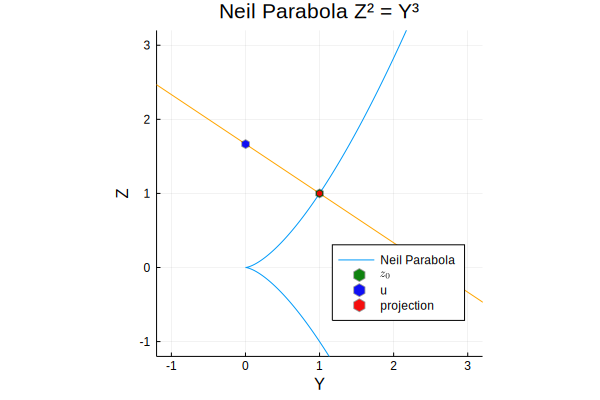

In [8]:
plothandle = plot([Tuple(s(x)) for x in -20:0.01:20 ], seriestype=:path, xlabel="Y", ylabel="Z", xlims=Tuple(z₀[1].+plotradius), ylims=Tuple(z₀[2].+plotradius),  aspect_ratio=:equal, legend=:bottomleft, label=string("Neil Parabola"), title="Neil Parabola Z² = Y³") 
ν(x) = vec(nullspace([∂(X=>x) for ∂ in Js]'))


# around singularity, three different setting occur. Uncomment the respective codeblocks to see the difference.

# === many-to-one setting ====

#for x in -0.5:0.03:0.5
    
#    normal_line_endpoints = x>0 ? (s(x), s(x)+6ν(x)) : (s(x)-6ν(x), s(x))
#    plot!([p[1] for p in normal_line_endpoints], [p[2] for p in normal_line_endpoints], legend=false, color=:orange)
#end

# === one-to-one setting =====
normal_line_endpoints = (z-6ν(x), z+6ν(x))
plot!([p[1] for p in normal_line_endpoints], [p[2] for p in normal_line_endpoints], label="", color=:orange)

# === one-to-many setting ====
# in the one-to-many case, the following calculation shows that we do not obtain moments of a dirac distribution, 
# but of a "symmetric" rank 2 distribution of the form δ_x + δ_{-x}, where both s(x) and s(-x) are nearest points to u
if u[2] == 0
    x = √value.(mommat)[2, 2]
    mon(k) = reverse(monomials(X, 0:k))
    display(0.5.*[p(X=>x) for p in mon(3)]*[p(X=>x) for p in mon(3)]' + 0.5*[p(X=>-x) for p in mon(3)]*[p(X=>-x) for p in mon(3)]' )
    display(value.(mommat))
    first_normal_line_endpoints = (s(x)-6ν(x), s(x)+6ν(x))
    second_normal_line_endpoints = (s(-x)-6ν(-x), s(-x)+6ν(-x))
    for endpoints in [first_normal_line_endpoints, second_normal_line_endpoints]
        plot!([p[1] for p in endpoints], [p[2] for p in endpoints], legend=false, color=:orange)
    end
    plot!([s(x)[1] for p in [s(x)+[0; 2], s(-x)-[0; 2]]], [p[2] for p in [s(x)+[0; 2], s(-x)-[0; 2]]], legend=false, color=:turquoise, linestyle=:dash) # dashed line connecting the two projections
    scatter!([Tuple(s(x)), Tuple(s(-x))], 
        markershape = :hexagon,
        markersize = 3,
        markeralpha = 0.9,
        markercolor = :orange,
        markerstrokealpha = 0.4,
        markerstrokecolor = :black,
        label="projection"
    )

end

scatter!(Tuple(z₀), 
    markershape = :hexagon,
    markersize = 4,
    markeralpha = 0.9,
    markercolor = :green,
    markerstrokealpha = 0.4,
    markerstrokecolor = :black,
    label=L"z_0"
)


scatter!(Tuple(u), 
    markershape = :hexagon,
    markersize = 4,
    markeralpha = 0.9,
    markercolor = :blue,
    markerstrokealpha = 0.4,
    markerstrokecolor = :black,
    label="u"
)

scatter!(Tuple(z), 
    markershape = :hexagon,
    markersize = 3,
    markeralpha = 0.9,
    markercolor = :red,
    markerstrokealpha = 0.4,
    markerstrokecolor = :black,
    label="projection"
)


plot(plothandle, legend=:bottomright)
#plot(plothandle, xlims=Tuple(z₀[1].+ [-.25, 1.75]), ylims=Tuple(z₀[2].+[-1, 1]))
